In [1]:
#| echo: false
import os
os.environ["OMP_NUM_THREADS"] = '1'

Medir el desempeño de los algoritmos de agrupamiento es complicado ya que, al ser un problema no supervisado, no tenemos las respuestas. No existe una correcta partición de los datos, todo depende del problema que se quiere resolver. Es por esto que comparar algoritmos diferentes o distintas corridas del mismo algoritmo es complejo y lo que se hace es evaluar la **calidad** de los clusters. Existen diferentes métodos de evaluación y suelen favorecer a cierto tipo de algoritmos.

## Inercia.

Se toma la suma de los cuadrados de las distancias de los puntos a su representante. Esto favorece a métodos como `kmeans` sobre el `DBSCAN`.

Los valores más bajos indican un mejor agrupamiento ya que las distancias de los puntos a los centroides es menor, lo que generalmente resulta en cluster mejor definidos.






In [2]:
#| echo: false
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

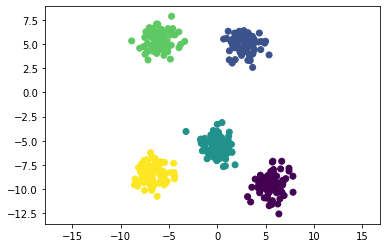

In [4]:
X, y = make_blobs(400, 2, centers=5, random_state=10)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

K-means tiene el atributo `inertia_` donde se guarda el valor de la inercia.

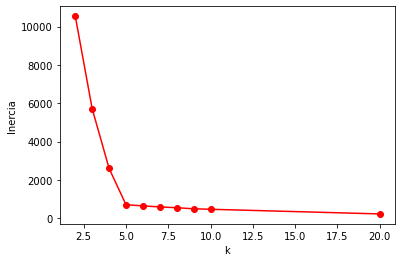

In [5]:
K = [2,3,4,5,6,7,8,9,10,20]
scores = []
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    s = km.inertia_
    #print(f"k: {k} inercia:{s}")
    scores.append(s)
plt.plot(K, scores, '-or')
plt.xlabel("k")
plt.ylabel('Inercia');

En la imagen se grafica el valor de la inercia contra el número de clusters. Como se puede ver, la inercia siempre va disminuyendo mientras el número de clusters aumenta. Se puede ver que en un inicio, la inercia baja de forma considerable hasta llegar a un punto de **quiebre**, después la disminución de la inercia se estabiliza y ya no varía mucho al aumentar un cluster.

Es en este punto de quiebre donde se encuentra la mejor $k$ para el conjunto de datos. A esta técnica se le conoce con el nombre del **técnica del codo** ya que la gráfica se parece a la de un brazo flexionado y buscamos la zona del **codo** para encontrar la mejor $k$.

## Razón de la distancia Intra-Cluster con Inter-Cluster.

Se toma un conjunto pequeño de pares de datos $(x_i, x_j)$, de ellos, sea P el conjunto de los pares que pertenecen al mismo cluster y Q el resto. Sean

$$Intra = \sum_{(x_i, x_j)\in P}\frac{d(x_i,x_j)}{|P|}$$
$$Inter = \sum_{(x_i, x_j)\in Q}\frac{d(x_i,x_j)}{|Q|}$$

La medida se define como $Intra/Inter$ y valores pequeños indican una mejor calidad de los clusters.

In [9]:
#| echo: false
def intra_inter(X, y, num_pairs):
    np.random.seed(0)
    pairs = np.random.randint(len(X), size = (num_pairs, 2)

    sum_inter = 0
    num_inter = 0
    sum_intra = 0
    num_intra = 0
    for pair in pairs:
        if y[pair[0]] == y[pair[1]]:  
            sum_intra += np.linalg.norm(X[pair[0]] - X[pair[1]])
            num_intra += 1
        else:
            sum_inter += np.linalg.norm(X[pair[0]] - X[pair[1]])
            num_inter += 1
    intra = sum_intra / num_intra
    inter = sum_inter / num_inter
    return intra / inter

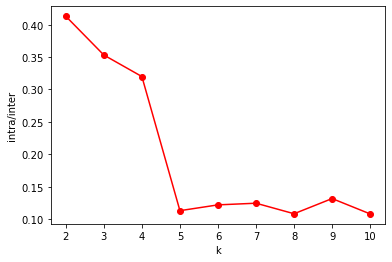

In [10]:
K = [2,3,4,5,6,7,8,9,10]
i_i = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    ii = intra_inter(X, y_kmeans, 200)
    i_i.append(ii)

plt.plot(K, i_i, '-or')
plt.xlabel("k")
plt.ylabel('intra/inter');

Como se aprecia en la figura, a partir del valor de $k=5$ se obtienen valores muy pequeños. Si se corre varias veces la métrica, se obtendrán valores ligeramente diferentes debido a la selección aleatoria de los pares de puntos. Este es un factor que hay que tomar en cuenta y se recomienda hacer varias corridas y elegir la mejor $k$ al evaluar todas.

## Silueta.

Sea $D_{in}(i)$ la distancia promedio de $x_i$ con los elementos de su cluster. Sea $D_{out}(i)$ la distancia promedio de $x_i$ con los elementos del cluster más cercano que no contiene a $x_i$. 
Entonces el coeficiente de silueta para $x_i$ es:

$$S_i = \frac{D_{out}(i)-D_{in}(i)}{\max(D_{out}(i),D_{in}(i))}$$

El coeficiente total es el promedio de los coeficientes para todos los datos. Toma valores entre -1 y 1 y valores positivos indican que los clusters están separados mientras que los valores negativos son señal de que los clusters se tocan.

Usaremos la función `silhuette_score` de sklearn para calcular esta métrica.

In [28]:
from sklearn.metrics import silhouette_score

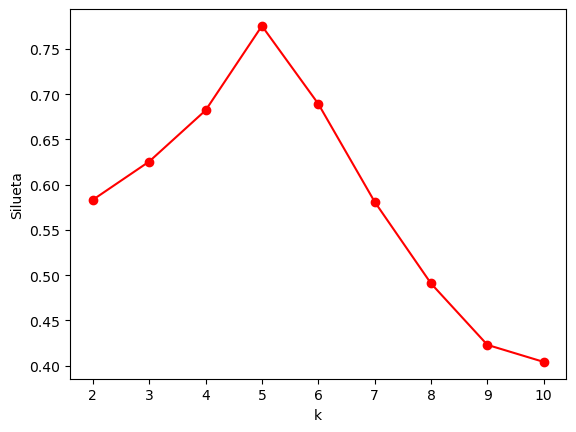

In [30]:
K = [2,3,4,5,6,7,8,9,10]
sil = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    score = silhouette_score(X, y_kmeans, metric='euclidean')
    sil.append(score)

plt.plot(K, sil, '-or')
plt.xlabel("k")
plt.ylabel('Silueta');

Como se puede ver, el valor más alto es cuando $k=5$ que es lo esperado. La métrica de la silueta es de las más usadas para evaluar la calidad de los clusters.